In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt, numpy as np, jdcal
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import griddata
import scipy.ndimage
from matplotlib.gridspec import GridSpec

plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [55]:
from astropy.io import fits
from astropy.visualization import LogStretch, ImageNormalize

# Main figure

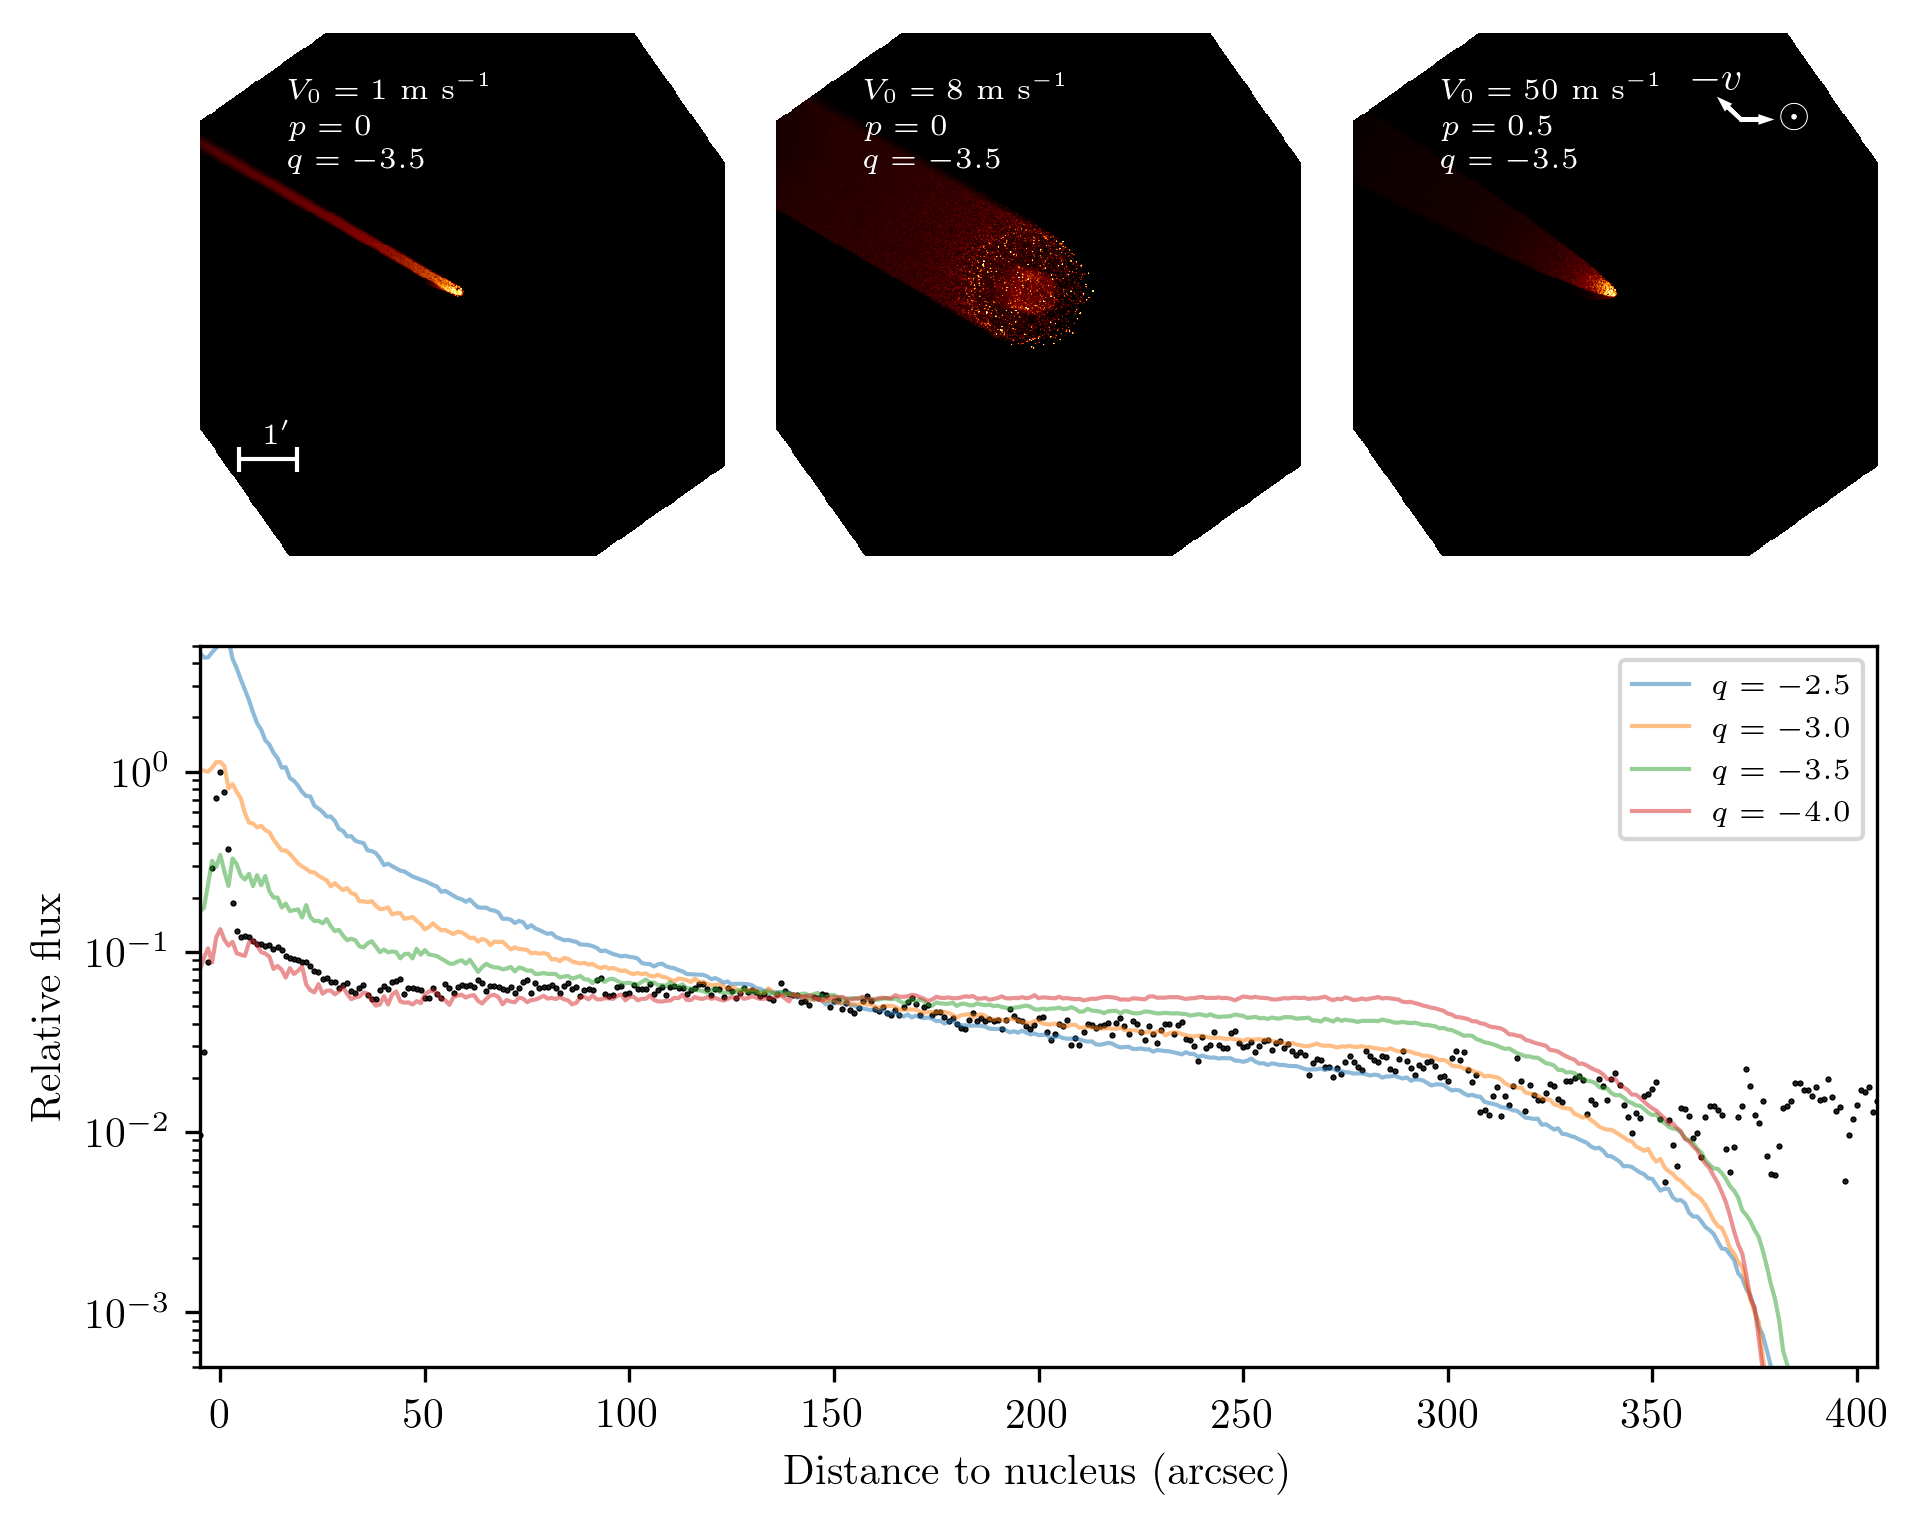

In [262]:
from matplotlib import gridspec

fig = plt.figure(figsize=(6.5, 5.5), dpi=300)
gs=GridSpec(2, 3)

for i, ii in enumerate(['./model/6478_model_20190208_0.7_-3.5_179.9.fits', './model/6478_model_20190208_8.3_-3.5_179.9.fits', \
                       './model/6478_model_20190208_50._-3.5_179.9.fits']):
    
    ax = fig.add_subplot(gs[0, i])
    
    ax.set_autoscale_on(False)

    ax.clear()
    ax.set_axis_off()
    
    cmap = 'afmhot'
    hdu_list = fits.open(ii)
    header = hdu_list[0].header
    image = hdu_list[0].data
    norm = ImageNormalize(image, stretch=AsinhStretch())
    
    if i == 1:
        ax.imshow(image, cmap=cmap, norm=norm, vmax=np.nanmax(image)*0.5, origin='lower')
    else:
        ax.imshow(image, cmap=cmap, norm=norm, origin='lower')
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    
    if i == 0:
        ax.errorbar(70, 100, xerr=30, lw=1, capsize=3, color='w')
        ax.text(67, 115, r"$1'$", fontsize='x-small', color='w')
        ax.text(90, 400, r'$V_0=1~\mathrm{m~s^{-1}}$' + '\n' + r'$p=0$' + '\n' + r'$q=-3.5$', fontsize='x-small', color='w')
    elif i == 1:
        ax.text(90, 400, r'$V_0=8~\mathrm{m~s^{-1}}$' + '\n' + r'$p=0$' + '\n' + r'$q=-3.5$', fontsize='x-small', color='w')
    elif i == 2:
        horizons = np.genfromtxt('horizons.txt', usecols=(0, 19, 20)).T
        hdu_list = fits.open('./stacks/6478-20190128-pre2.430-zr-ztf-stack.fits')
        header = hdu_list[0].header
        
        psang = horizons[1][(np.abs(horizons[0]-header['OBSJDM'])).argmin()]
        psamv = horizons[2][(np.abs(horizons[0]-header['OBSJDM'])).argmin()]
        dx = 20*np.cos(np.deg2rad(psang-psamv+180))
        dy = -20*np.sin(np.deg2rad(psang-psamv+180))
        ax.arrow(400, 450, dx, dy, head_width=5, color='w')
        ax.text(400+70*np.cos(np.deg2rad(psang-psamv+180)), 450-50*np.sin(np.deg2rad(psang-psamv+180)), '$-v$', \
           weight='black', color='w')
        ax.arrow(400, 450, 20, 0, head_width=5, color='w')
        ax.text(440, 443, '$\odot$', weight='black', color='w')
        ax.text(90, 400, r'$V_0=50~\mathrm{m~s^{-1}}$' + '\n' + r'$p=0.5$' + '\n' + r'$q=-3.5$', fontsize='x-small', color='w')

ax = fig.add_subplot(gs[1, :])

hdu_list = fits.open('./model/6478-20190208.fits')
header = hdu_list[0].header
image = hdu_list[0].data.T

x = []
y = []

for i, v in enumerate(image):
    x.append(i)
    y.append(np.nansum(v[530:550]))

x = np.array(x)
y = np.array(y)
        
ax.plot((x - x[y.argmax()]), y/np.max(y), 'k.', markersize=1)
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(-5, 405)
ax.set_ylim(5e-4, 5)
ax.set_xlabel('Distance to nucleus (arcsec)')
ax.set_ylabel('Relative flux')

y100 = (y/np.max(y))[y.argmax()+140]

for i, ii in enumerate(['./model/6478_model_20190208_0.7_-2.5_179.9_q.fits', './model/6478_model_20190208_0.7_-3._179.9_q.fits', \
                       './model/6478_model_20190208_0.7_-3.5_179.9_q.fits', './model/6478_model_20190208_0.7_-4._179.9_q.fits']):
    hdu_list = fits.open(ii)
    header = hdu_list[0].header
    image = hdu_list[0].data.T

    x = []
    y = []

    for j, v in enumerate(image):
        x.append(j)
        y.append(np.nansum(v))

    x = np.array(x)
    y = np.array(y)
    
    if i == 0:
        ax.plot((x - x[y.argmax()]), y/y[y.argmax()+140]*y100, '-', alpha=0.5, linewidth=1, label=r'$q=-2.5$')
    elif i == 1:
        ax.plot((x - x[y.argmax()]), y/y[y.argmax()+140]*y100, '-', alpha=0.5, linewidth=1, label=r'$q=-3.0$')
    elif i == 2:
        ax.plot((x - x[y.argmax()]), y/y[y.argmax()+140]*y100, '-', alpha=0.5, linewidth=1, label=r'$q=-3.5$')
    elif i == 3:
        ax.plot((x - x[y.argmax()]), y/y[y.argmax()+140]*y100, '-', alpha=0.5, linewidth=1, label=r'$q=-4.0$')

ax.legend(fontsize='x-small')

fig.tight_layout()
plt.savefig('dust_model.pdf')
plt.show()

# Aperture window

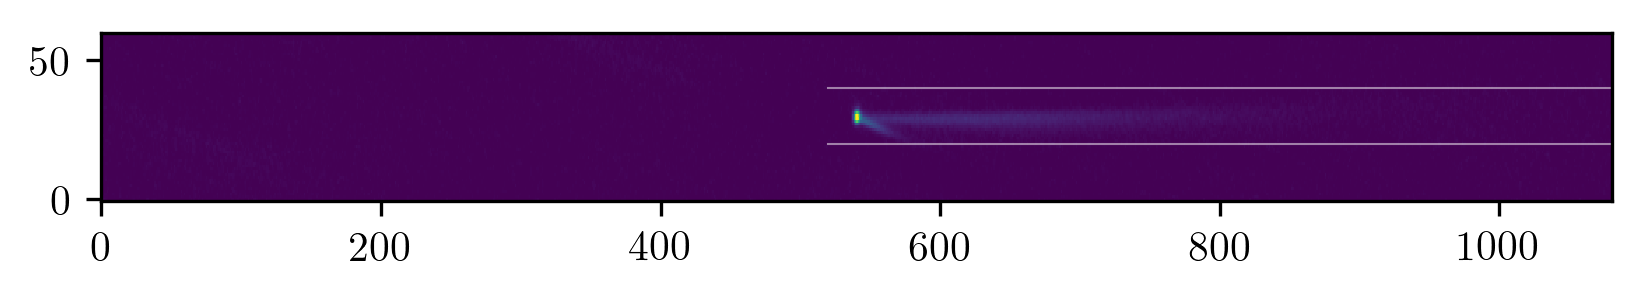

In [238]:
import matplotlib.patches as patches
from astropy.visualization import AsinhStretch, ZScaleInterval

plt.figure(figsize=(6.5, 5.5), dpi=300)

hdu_list = fits.open('./model/6478-20190208.fits')
header = hdu_list[0].header
image = hdu_list[0].data.T

plt.imshow(image.T[510:570], norm=ImageNormalize(image, stretch=AsinhStretch()), vmin=np.nanmean(image), vmax=np.nanmax(image), \
           origin='lower', aspect=2)
plt.plot([520, 1080], [20, 20], 'w-', alpha=0.5, lw=0.5)
plt.plot([520, 1080], [40, 40], 'w-', alpha=0.5, lw=0.5)
plt.show()